<a href="https://colab.research.google.com/github/yishairasowsky/Sefaria-Project/blob/master/ML/topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd

In [0]:
prayer_df = pd.read_csv('/content/prayer-sources.csv', 
                        # encoding="latin-1"
                        encoding="utf-8"
                        )
# not_prayer_df = pd.read_csv('/content/not-prayer-sources.csv', 
not_prayer_df = pd.read_csv('/content/not-prayer-sources-more.csv', 
                            # encoding="latin-1"
                              encoding="utf-8"
                            )

In [54]:
prayer_df.sample(3)

,Ref,En,He
484,Berakhot 28b:3,MISHNA: In addition to the halakhot relating t...,מַתְנִי׳ רַבִּי נְחוּנְיָא בֶּן הַקָּנָה הָיָה...
34,Berakhot 60a:20-23,The Sages taught the details of Ben Azzai’s te...,תָּנוּ רַבָּנַן: בִּכְנִיסָתוֹ מַהוּ אוֹמֵר? —...
684,Rosh Hashanah 35a:7-8,§ Rabbi Elazar said: A person should always ar...,"אמר ר""א לעולם יסדיר אדם תפלתו ואח""כ יתפלל אמר ..."


In [55]:
prayer_df['is_prayer'] = 'yes'
prayer_df = prayer_df[['En','is_prayer']]

prayer_df.tail(3)

,En,is_prayer
1049,"It is true that you are the one who judges, an...",yes
1050,In these Berachot (blessings) we bow down: the...,yes
1051,On seeds he says [the Beracha (blessing)] Bore...,yes


In [56]:
not_prayer_df.sample(3)

,Ref,En,He,Topics
9283,Bava Metzia 112a:12,The Gemara suggests: Let us say that the follo...,נימא מסייעא ליה הנותן טליתו לאומן גמרה והודיעו...,laws-of-engagement-of-workers|procedures-for-j...
1566,Bekhorot 36b:14,GEMARA: What is the reason that even the owner...,"גמ׳ מ""ט דאי בעי שדי ביה מומא מעיקרא מי ידע הי ...",laws-of-judges-and-courts
3916,Zohar 1:7a:3,"3. Rabbi Elazar said, ""O, how great is Your go...","פָּתַח רִבִּי אֶלְעָזָר (ל''א ב', מ''ו א', י''...",cecum


In [57]:
not_prayer_df['is_prayer'] = 'no'
not_prayer_df = not_prayer_df[['En','is_prayer']]
not_prayer_df.sample(3)

,En,is_prayer
8836,NaN,no
5672,The yavam is forbidden to marry any of the rel...,no
9077,The mishna cites another custom related to Pas...,no


In [58]:
all_prayer_frames = [prayer_df, not_prayer_df]
all_prayer_df = pd.concat(all_prayer_frames)
all_prayer_df.reset_index(inplace=True)
all_prayer_df=all_prayer_df.rename(columns = {'En':'english_text'})


# all_prayer_df.style.set_properties({'align': 'right'})

# all_prayer_df.tail(3)
all_prayer_df.sample(5)
# all_prayer_df.loc[[345]]

,index,english_text,is_prayer
10919,9867,NaN,no
7373,6321,Rav Ḥanan bar Rav Ḥisda said: It is not diffic...,no
2256,1204,NaN,no
3103,2051,NaN,no
1507,455,Abaye raised an objection to Rabba from a bara...,no


In [59]:
del all_prayer_df['index']

all_prayer_df.sample(3)

,english_text,is_prayer
5488,The words היה רעה את אחיו בצאן refer to the sh...,no
8744,Rav Huna bar Taḥalifa said: Now that the halak...,no
6651,§ The mishna teaches that if one decreased its...,no


In [60]:
print("Before dropping duplicates",all_prayer_df.shape)
all_prayer_df.drop_duplicates(inplace=True)
print("After dropping duplicates",all_prayer_df.shape)

print("\nNulls before dropping:",all_prayer_df.isnull().sum()[0])
all_prayer_df.dropna(inplace=True)
print("Nulls after dropping:",all_prayer_df.isnull().sum()[0])

# all_prayer_df.isnull().sum()
# all_prayer_df.sample(5)

Before dropping duplicates (11553, 2)
After dropping duplicates (6948, 2)

Nulls before dropping: 2
Nulls after dropping: 0


In [61]:
shape = all_prayer_df.shape
print(f"{shape[0]} rows and {shape[1]} columns")

6946 rows and 2 columns


In [62]:
all_prayer_df['is_prayer'] = all_prayer_df['is_prayer'].map({'no': 0, 'yes': 1})
all_prayer_df.sample(5)

,english_text,is_prayer
4075,And Rabbi Yoḥanan says: The court collects fro...,0
1868,17. If Reuven makes a claim against Shimon and...,0
8073,"Of the tribe of Zebulun, Gaddiel the son of Sodi.",0
9587,Ulla said: Even if you say that the halakha wi...,0
10173,"For example, the air that is breathed - since ...",0


In [63]:
print('Prayer:', (all_prayer_df.is_prayer.values == 1).sum())
print('Not prayer:', (all_prayer_df.is_prayer.values == 0).sum())

Prayer: 553
Not prayer: 6393


In [64]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_ \b\d+\b]')
STOPWORDS = set(stopwords.words('english'))

def process_text(text):
    #  text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# whitelist = set('abcdefghijklmnopqrstuvwxyz ZXCVBNMASDFGHJKLQWERTYUIOP')
# genres['movie_id'] = genres['movie_id'].astype(str)

# def process_text(text):
#     '''
#     1. Keep only letters and spaces
#     2. Remove stopwords
#     3. Return str of clean text words
#     '''
#     #1
#     chars_str = ''.join(filter(whitelist.__contains__, text))
#     #2
#     clean_words = [word.lower() for word in chars_str.split() if word.lower() not in stopwords.words('english')]
#     #3
#     return ' '.join(clean_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
sample_text = '''aBC.!@#$%^&    c*(בחתו ‎‎‎ או‎ בקרחתו — une...
233 the gns: ac ...
1041    7. a pien p'''
process_text(sample_text)

'abc # c une233 gns ac 1041 7 pien p'

In [66]:
all_prayer_df.sample(5)

,english_text,is_prayer
2775,"Thy raiment waxed not old upon thee, neither d...",0
7292,"1. The Law of an Old Sukkah, 2 Seifim: An old ...",0
1579,"10) ""and writing that is engraved"": I might th...",0
36,"Since the verse: “Prepare to greet your God, I...",1
7532,"Salted food, that one is unable to eat because...",0


In [67]:
processed_df = all_prayer_df
processed_df['english_text'] = processed_df['english_text'].apply(process_text)
processed_df.head(5)

,english_text,is_prayer
0,another abba binyamins statements regard laws ...,1
1,taught baraita abba binyamin said ones prayer ...,1
2,additionally ravin bar rav adda said rabbi yit...,1
3,similarly taught baraita rabbi yishmael ben el...,1
4,meaning written let prayer unto lord time favo...,1


In [68]:
# all_prayer_df['En'] = all_prayer_df['En'].apply(stemming)
# all_prayer_df.head()
stemmed_df = processed_df
stemmed_df['english_text'] = stemmed_df['english_text'].apply(stemming)
stemmed_df.head()

,english_text,is_prayer
0,anoth abba binyamin statement regard law praye...,1
1,taught baraita abba binyamin said one prayer f...,1
2,addit ravin bar rav adda said rabbi yitzak sai...,1
3,similar taught baraita rabbi yishmael ben elis...,1
4,mean written let prayer unto lord time favor g...,1


In [0]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# prayer_words = ' '.join(list(all_prayer_df[stemmed_df['is_prayer'] == 1]['En']))
# prayer_wc = WordCloud(width = 512,height = 512).generate(prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [0]:
# not_prayer_words = ' '.join(list(all_prayer_df[all_prayer_df['is_prayer'] == 0]['En']))
# not_prayer_wc = WordCloud(width = 512,height = 512).generate(not_prayer_words)
# plt.figure(figsize = (10, 8), facecolor = 'k')
# plt.imshow(not_prayer_wc)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

In [0]:
df = stemmed_df

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['english_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 15093 unique tokens.


In [73]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['english_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (6946, 250)


In [74]:
Y = pd.get_dummies(df['is_prayer']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (6946, 2)


In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(6251, 250) (6251, 2)
(695, 250) (695, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, SpatialDropout1D
# from tensorflow.python.keras.layers.recurrent import LSTM
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [0]:
# X = df.english_text
# y = df.is_prayer
# print(f"Totals: {X.shape} / {y.shape}")

# from sklearn.model_selection import train_test_split

# # train, test = train_test_split(movies, random_state=42, test_size=0.30, shuffle=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, test_size=0.20, shuffle=True)

# print(f"\nTrain: {X_train.shape} / {y_train.shape}")

# print(f"\nTest: {X_test.shape} / {y_test.shape}")

In [78]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

history = model.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5625 samples, validate on 626 samples
Epoch 1/15
5625/5625 [==============================] - 39s 7ms/step - loss: 0.3261 - accuracy: 0.9156 - val_loss: 0.2334 - val_accuracy: 0.9377
Epoch 2/15
5625/5625 [==============================] - 38s 7ms/step - loss: 0.2616 - accuracy: 0.9200 - val_loss: 0.1934 - val_accuracy: 0.9377
Epoch 3/15
5625/5625 [==============================] - 38s 7ms/step - loss: 0.1492 - accuracy: 0.9429 - val_loss: 0.1303 - val_accuracy: 0.9601
Epoch 4/15
5625/5625 [==============================] - 38s 7ms/step - loss: 0.0916 - accuracy: 0.9657 - val_loss: 0.1428 - val_accuracy: 0.9569
Epoch 5/15
5625/5625 [==============================] - 38s 7ms/step - loss: 0.0569 - accuracy: 0.9812 - val_loss: 0.1672 - val_accuracy: 0.9553
Epoch 6/15
5625/5625 [==============================] - 38s 7ms/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.2120 - val_accuracy: 0.9505


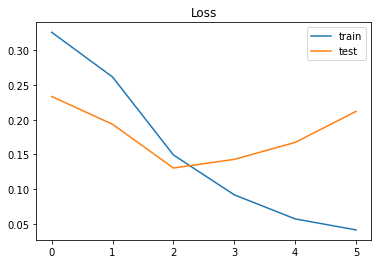

In [79]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


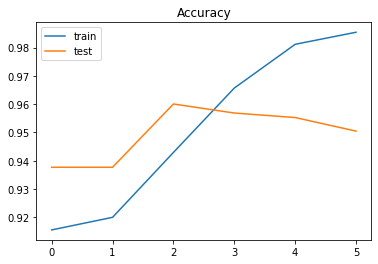

In [80]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [0]:
# # Convert a collection of text documents to a matrix of token counts

# from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

# # vectorizer = CountVectorizer(analyzer=process_text)
# # vectorizer = CountVectorizer(ngram_range=(2, 4))
# # vectorizer = HashingVectorizer(ngram_range=(2, 4),alternate_sign=False)
# vectorizer = TfidfVectorizer(
#     # strip_accents='unicode', 
#     # analyzer='word', 
#     ngram_range=(1,3), 
#     # norm='l2', 
#     # max_features = 15000
#     # max_features = 12000
#     max_features = 10000
#     # max_features = 8000
#     # max_features = 5000
#     )

# # vectorizer = TfidfVectorizer(ngram_range=(2, 4))
# # vectorizer.fit(X_train)
# # vectorizer.get_feature_names()


In [0]:
# print("Shape of document term matrix")

# # X_train_dtm = vectorizer.transform(X_train)
# X_train_dtm = vectorizer.fit_transform(X_train)
# print(f"Train: {X_train_dtm.shape}")

# # prayer_bag_of_words = vectorizer.fit_transform(all_prayer_df['En'])
# X_test_dtm = vectorizer.transform(X_test)
# print(f"Test: {X_test_dtm.shape}")


In [0]:

# print(vectorizer.get_feature_names())


In [0]:
# from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB

# classifier = MultinomialNB()
# # classifier = ComplementNB()

# # for Gaussian need array format
# # X_train = X_train.toarray()
# # X_test = X_test.toarray()
# # classifier = GaussianNB()
# # classifier = BernoulliNB()

# %time classifier.fit(X_train_dtm, y_train)
# y_pred_class = classifier.predict(X_test_dtm)
# from sklearn import metrics

# print(f"\nBreakdown:\n{y_test.value_counts()[0]} non-prayer (0), and\n{y_test.value_counts()[1]} prayer (1)")

# null_accuracy = y_test.value_counts().head(1) / len(y_test)
# print(f'\nNull accuracy: {null_accuracy[0]}')

# non_prayer_passages = y_test.value_counts()[0]
# prayer_passages = y_test.value_counts()[1]
# print('Manual null accuracy:',(prayer_passages / (prayer_passages + non_prayer_passages)))

# print('\nAccuracy:',round(metrics.accuracy_score(y_test, y_pred_class),2))
# print('Precision:',round(metrics.precision_score(y_test, y_pred_class),2))
# print('Recall:',round(metrics.recall_score(y_test, y_pred_class),2))
# print('F1 score:',round(metrics.f1_score(y_test, y_pred_class),2))

# print("\nConfusion Matrix:")
# print(metrics.confusion_matrix(y_test, y_pred_class))


In [0]:

# from sklearn.model_selection import cross_val_score
# # clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(classifier, X, y, cv=5)
# scores


In [0]:
# TP = X_test[y_pred_class + y_test == 2]
# TN = X_test[y_pred_class + y_test == 0]
# FP = X_test[y_pred_class > y_test]
# FN = X_test[y_pred_class < y_test]

# pd.options.display.max_colwidth = 100

# # pd.style.set_properties(**{'text-align': 'left'})

# # print("\n*** TP ***")
# # print(TP.sample(5))
# # print("\n*** TN ***")
# # print(TN.sample(5))
# print("*** False Positives: Actually NOT prayer, but misclassified as prayer ***\n")
# print(FP.sample(10))
# print("\n\n*** False Negatives: Actually prayer, but misclassified as NOT prayer ***\n")
# print(FN.sample(10))

In [0]:
# FP.to_csv('FP', sep='\t', encoding='utf-8')
# FN.to_csv('FN', sep='\t', encoding='utf-8')
